In [226]:
import matplotlib as mpl
import pandas as pd
from pandas.plotting import scatter_matrix
import xgboost as xgb

#Full Time Result (H=Home Win, D=Draw, A=Away Win)
#HTGD - Home team goal at the end of the game
#ATGD - away team goal at the end of the game

raw_data_1 = pd.read_csv('./season-1819.csv')

columns_req = ['HTHG','HTAG','FTR']
columns_req1 = ['HomeTeam','AwayTeam']
dataTeams = raw_data_1[columns_req1]
data = raw_data_1[columns_req]
data[0:20]
#Eintragen der Halbzeittore der Heimmannschaft
data.at[81, 'HTHG'] = 1
#Eintragen der Halbzeittore der Auswärtsmannschaft
data.at[81, 'HTAG'] = 0
#Eintragen des Erwarteten Endergebnisses
data.at[81, 'FTR'] = "H"
print(data[81:82])
dataTeams[81:82] 

    HTHG  HTAG FTR
81     1     0   H


,HomeTeam,AwayTeam
81,Dortmund,M'gladbach


Es sind  82 gespielt worden
Es sind  2 Features im Datensatz
Die Heimmannschaft hat  36 mal gewonnen
Die Auswärtsmannschaft hat  24 mal gewonnen
Es gab  22  Unentschieden
Die Heimmannschaft gewinnt zu  43.90243902439025 %
Die Auswärtsmannschaft gewinnt zu  29.268292682926827 %
Die Wahrscheinlichkeit für ein Unentschieden war  26.82926829268293 %


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b3c8b7d68>,
      dtype=object)

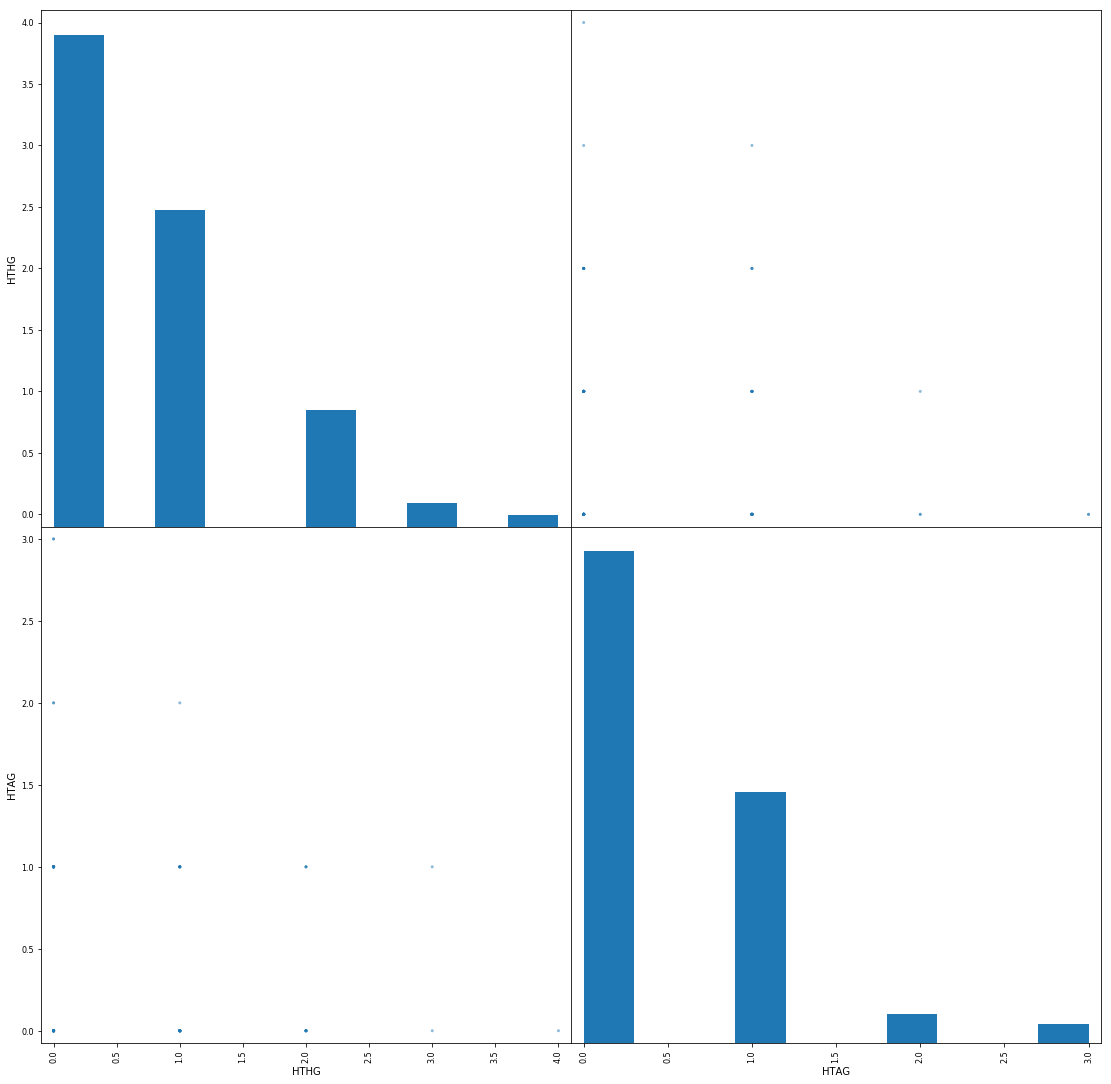

In [227]:
#Anzahl der Spiele
n_matches = data.shape[0]
n_features = data.shape[1]-1
n_homewins = len(data[data.FTR == 'H'])
n_awaywins = len(data[data.FTR == 'A'])
n_draw = len(data[data.FTR == 'D'])
win_rate_home = ((n_homewins) / (n_matches)) * 100
win_rate_away = ((n_awaywins) / (n_matches)) * 100
draw_rate = ((n_draw) / (n_matches)) * 100


print("Es sind ", n_matches, "gespielt worden")
print("Es sind ", n_features, "Features im Datensatz")
print("Die Heimmannschaft hat ",n_homewins, "mal gewonnen")
print("Die Auswärtsmannschaft hat ",n_awaywins, "mal gewonnen")
print("Es gab ",n_draw, " Unentschieden")
print("Die Heimmannschaft gewinnt zu ",win_rate_home, "%")
print("Die Auswärtsmannschaft gewinnt zu ",win_rate_away, "%")
print("Die Wahrscheinlichkeit für ein Unentschieden war ",draw_rate, "%")
scatter_matrix(data[['HTHG','HTAG']], figsize=(19,19))

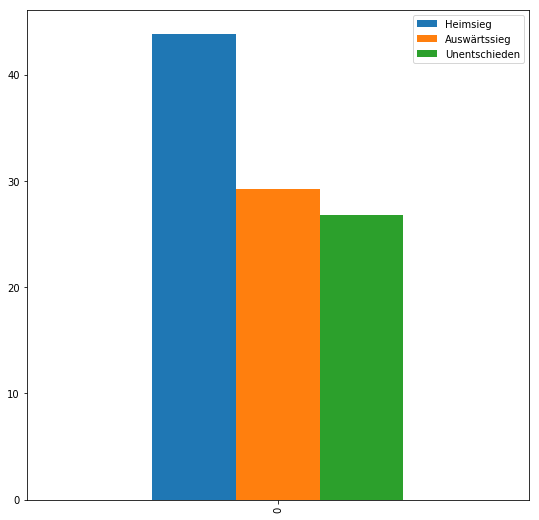

In [228]:
d = {'Heimsieg': [win_rate_home], 'Auswärtssieg': [win_rate_away], 'Unentschieden': [draw_rate]}
df = pd.DataFrame(data=d)
df.plot.bar(figsize=(9,9));

/home/lennard/PycharmProjects/MachineLearning/venv/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


,HTHG,HTAG
0,0.352392,-0.677277
1,0.352392,-0.677277
2,-0.803455,0.784215
3,0.352392,-0.677277
4,-0.803455,-0.677277


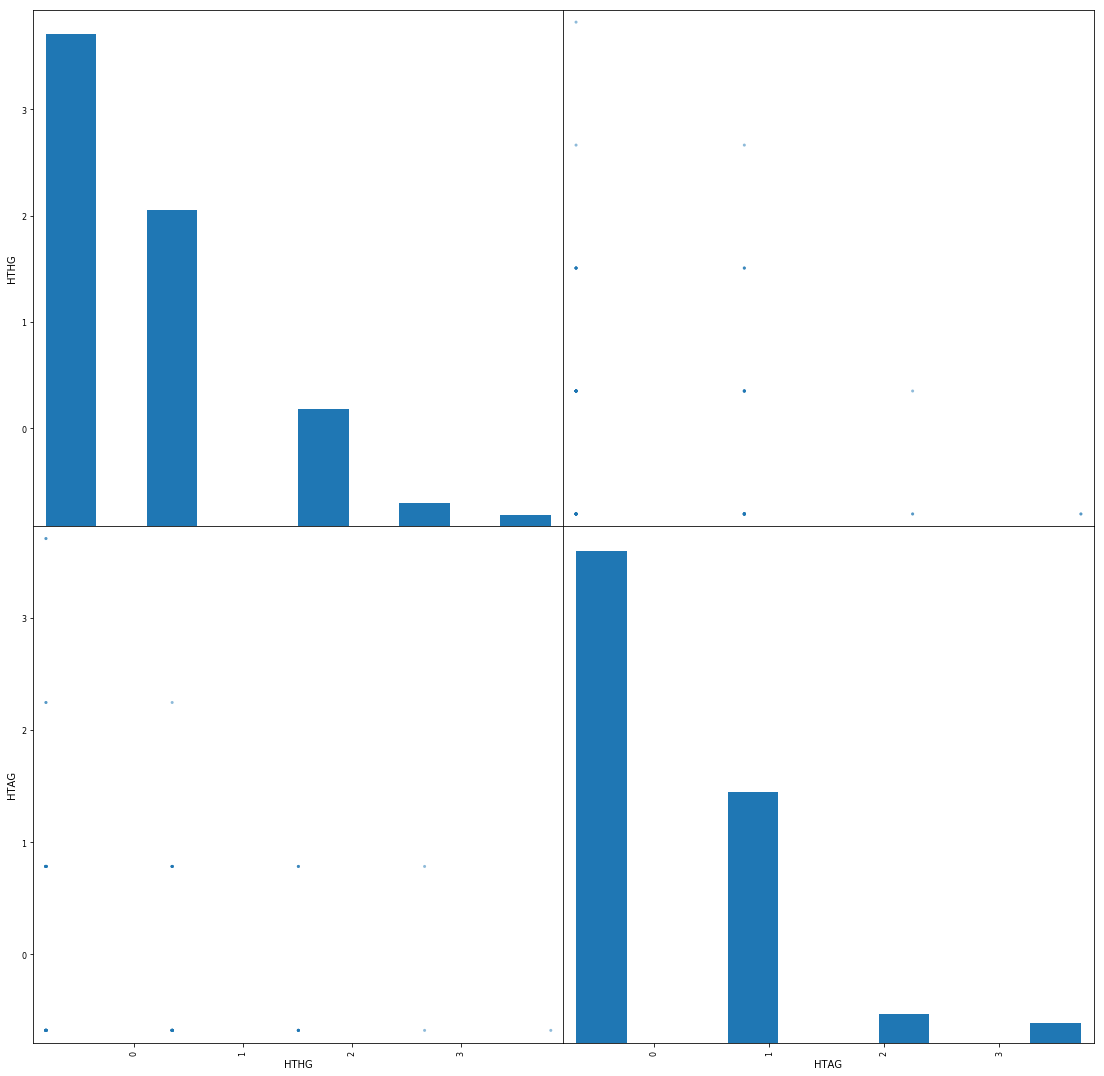

In [229]:
X_all = data.drop(['FTR'],1)
y_all = data['FTR']

# Standardising the data.
from sklearn.preprocessing import scale

#Center to the mean and component wise scale to unit variance.
cols = [['HTHG','HTAG']]
for col in cols:
    X_all[col] = scale(X_all[col])
scatter_matrix(X_all[['HTHG','HTAG']], figsize=(19,19))
X_all[0:5]

In [230]:
from sklearn.model_selection import train_test_split

# Shuffle and split the dataset into training and testing set.
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 40,
                                                    random_state = 2,
                                                    stratify = y_all)
X_train1, X_test1, y_train1, y_test1 = train_test_split(dataTeams, dataTeams, 
                                                    test_size = 40,
                                                    random_state = 1,
                                                    stratify = y_all)


In [231]:
def train_classifier(clf, X_train, y_train):
    
    clf.fit(X_train, y_train)
    
def predict_labels(clf, spiel):
    spiel1 = spiel - 1
    y_pred1 = clf.predict(X_all[spiel1:spiel])
    #print(y_pred1)
    if (y_pred1 == "H"):
        ergebnis = "Heimsieg"
    elif (y_pred1 == "A"):
        ergebnis = "Auswärtssieg"
    elif (y_pred1 == "D"):
        ergebnis = "Unentschieden"
    print("Die Prediciton für das Spiel",dataTeams.at[spiel1 ,'HomeTeam'] ,"gegen ", dataTeams.at[spiel1 ,'AwayTeam'], " Spiel ist ",ergebnis)
    return y_pred1
    
def train_predict(clf, X_train, y_train, X_test, y_test):
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    return predict_labels(clf, 17)
 

In [232]:
clf_C = xgb.XGBClassifier(seed = 82)

In [233]:
print(train_predict(clf_C, X_train, y_train, X_test, y_test))

Die Prediciton für das Spiel RB Leipzig gegen  Fortuna Dusseldorf  Spiel ist  Heimsieg
['H']


In [234]:
counter = 0
for i in range(1,83):
    test = data.at[i-1,'FTR'] == predict_labels(clf_C, i)
    print(data.at[i-1,'FTR'])
    if(test == False):
        counter += 1
        if (data.at[i-1,'FTR'] == "H"):
            ergebnis = "Heimsieg"
        elif (data.at[i-1,'FTR'] == "A"):
            ergebnis = "Auswärtssieg"
        elif (data.at[i-1,'FTR'] == "D"):
            ergebnis = "Unentschieden"
        print()
        print ("und das ist FALSCH. Der Richtige Wert wäre ", ergebnis)
        print()
print(counter)

Die Prediciton für das Spiel Bayern Munich gegen  Hoffenheim  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel Fortuna Dusseldorf gegen  Augsburg  Spiel ist  Heimsieg
A

und das ist FALSCH. Der Richtige Wert wäre  Auswärtssieg

Die Prediciton für das Spiel Freiburg gegen  Ein Frankfurt  Spiel ist  Auswärtssieg
A
Die Prediciton für das Spiel Hertha gegen  Nurnberg  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel M'gladbach gegen  Leverkusen  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel Werder Bremen gegen  Hannover  Spiel ist  Heimsieg
D

und das ist FALSCH. Der Richtige Wert wäre  Unentschieden

Die Prediciton für das Spiel Wolfsburg gegen  Schalke 04  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel Dortmund gegen  RB Leipzig  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel Mainz gegen  Stuttgart  Spiel ist  Heimsieg
H
Die Prediciton für das Spiel Hannover gegen  Dortmund  Spiel ist  Heimsieg
D

und das ist FALSCH. Der Richtige Wert wäre  Unentschieden

Die Prediciton 

In [235]:
print("Die Prediciton liegt zu ", 100-(((counter) / (n_matches)) * 100), "Prozent richtig!!!!")

Die Prediciton liegt zu  65.85365853658536 Prozent richtig!!!!
